# Морфинг изображений на примере датасета MNIST

Для начала подключим необходимые библиотеки.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

Функция для создания Dataloader'ов для train и test.

In [2]:
def get_data_loader(batch_size, train):

    dataset = datasets.MNIST('mnist', train=train, download=True, transform=transforms.ToTensor())
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return loader

Создадим train датасет, используя написанную функцию.

In [3]:
train = get_data_loader(64, True)

Для простого морфинга будем использовать autoencoder с линейными слоями.

In [4]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decode(self.encode(x))

Теперь создадим объект нашего класса. В качестве оптимизатора будем использовать Adam, в качестве лосса - MSE.

In [5]:
device = torch.device('cuda:0')
lin_autoenc = LinearAutoencoder().to(device)

lin_optimizer = torch.optim.Adam(lin_autoenc.parameters())
lin_criterion = nn.MSELoss()

Здесь описана функция обучения модели. 

Из-за того, что мы будем использовать как сети с линейными слоями, так и со свертками, приходится передавать дополнительный параметер lin. Он влияет на формат данных, которые мы передаем в нейросеть.

In [6]:
def train_model(model, optimizer, criterion, num_epochs=20, lin=True):
    history = []
    for i in tqdm.tqdm_notebook(range(num_epochs)):
        epoch_loss = 0
    
        for x, _ in train:
            if lin:
                x = x.view(-1, 28*28).to(device)
            else:
                x = x.view(-1, 1, 28, 28).to(device)
        
            optimizer.zero_grad()

            outp = model(x)
            loss = criterion(outp, x)
            loss.backward()
            
            epoch_loss += loss.item()
            optimizer.step()
        
        history.append(epoch_loss / 64)

    return (model, history)

Далее опишем функцию для создания анимации. Она работает следующим образом:
1. Выберем 2 изображения и переведем их с помощью .encode() в точки в 16-мероном пространстве. 
1. Мысленно соединим их отрезком и равномерно возьмем steps точек на нем.
1. С помощью .decode() восстановим из этих точек ожидаемое изображение.

Таким образом мы получим плавный переход между двумя изображениями цифр.

Функция morph принимает 4 параметра:
1. model - используемая модель.
1. count - количество изображений, между которыми будет происходить морфинг. Сами картинки будут выбраны случайным образом.
1. steps - количество точек(шагов) на отрезке между изображениями.
1. delay - задержка.

In [7]:
import numpy as np
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [8]:
def get_lin(pos):
    return train.dataset[pos][0].view(-1, 28*28).to(device)

def get_conv(pos):
    return train.dataset[pos][0].view(-1, 1, 28, 28).to(device)

def imshow(image):
    picture = image.cpu().numpy().astype('float64')
    plt.axis('off')
    return plt.imshow(picture, cmap='Greys', animated=True)

def morph(model, count, steps, delay, lin=True):
    indices = np.random.randint(0, len(train.dataset), count)
    if lin:
        latent = [model.encode(get_lin(i)).data for i in indices]
    else:
        latent = [model.encode(get_conv(i)).data for i in indices]
    
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            curr = (1 - t) * a + t * b

            morphed = model.decode(curr).data.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)
    display(HTML(ani.to_html5_video()))

Обучим сеть с линейными слоями. Так же проверим, что обучение прошло корректно и лосс с каждой эпохой действительно убывал.

In [9]:
lin_autoenc, history = train_model(lin_autoenc, lin_optimizer, lin_criterion)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


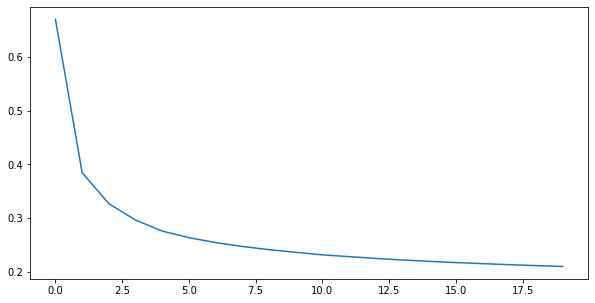

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history)

Вызовем функцию morph для создания анимации.

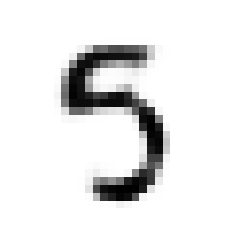

In [11]:
morph(lin_autoenc, 10, 20, 30)

Теперь вместо линейных слоев попробуем свертки.

In [12]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),

            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(),

            nn.Conv2d(32, 64, (3, 3), padding=1),
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, (3, 3), padding=1),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, (3, 3), padding=1),
            nn.ReLU(),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 1, (3, 3), padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.decode(self.encode(x))

In [13]:
conv_autoenc = ConvAutoencoder().to(device)

conv_optimizer = torch.optim.Adam(conv_autoenc.parameters())
conv_criterion = nn.MSELoss()

Обучим модель и проверим, что обучение прошло корректно.

In [14]:
conv_autoenc, history = train_model(conv_autoenc, conv_optimizer, conv_criterion, lin=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


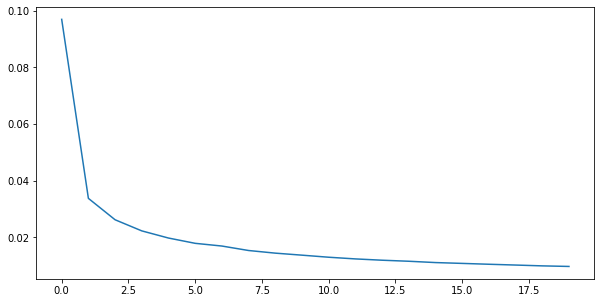

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(history)

Посмотрим на итоговый результат.

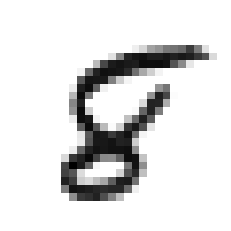

In [18]:
morph(conv_autoenc, 5, 50, 30, lin=False)

Таким образом, получили 2 отличайющиеся анимации. Нейросеть с линейными слоями позволяет создать более плавную гифку переходов. 

Свертки же делают ее более резкой, хотя увеличив количество точек на отрезке или задержку можно все же увидеть плавность переходов.